### DFRとVFRの未来の擾乱に対する計画収束速度で比較する

仮説: DFRで運行すると未来の擾乱に対する周りの人（自分の決定に影響を及ぼしうる人）の反応が瞬時にわかるため、VFRと比べた際に擾乱に対する収束速度が高まる。その結果として交通キャパシティが上昇する。

この仮説をシミュレーション実験によって確かめる。

#### 組むべき実験系
- ノイズは1個だけ（複数にも対応できるようにはしているが速度計算周りが怪しい）


In [1]:
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd
import sys
import copy

sys.path.append("../")
from models import Cars, ReservationTable, DFRSimulation
from utils import check_multiple_noise_effect, validate_with_ttc

# ↑↑↑↑↑↑↑↑↑この部分は別セルでも良い↑↑↑↑↑↑↑↑↑

# 初期設定（独立変数群）
CAR_NUM = 10 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 1000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
MEAN_SPEED = 20 # 秒速[m/s]として定義
MAX_SPEED = 30 # 秒速[m/s]として定義
MAX_ACC = 3 # m/s^sで定義, maxは0.3gにした
TIME_STEP = 0.1
COMMUNICATION_SPEED = 0.1
TOTAL_TIME = 1
V_MAX = 40
GLOBAL_TIME_WINDOW = 60  # Strategic Phaseでの時間幅
TTC = 2 #車間時間を暫定的に定義


In [2]:
# 従属的に決まるもの
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0

arrival_times = sorted([random.uniform(0, GLOBAL_TIME_WINDOW) for _ in range(CAR_NUM)])
arrival_times = [0.4,4,8,11,30, 40,50,60,70,80,]
CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
              for index, time in enumerate(arrival_times)]

    waypoint_idx       x    eta  car_idx      type
0              0     0.0    0.4        0  waypoint
1              1   100.0    5.4        0  waypoint
2              2   200.0   10.4        0  waypoint
3              3   300.0   15.4        0  waypoint
4              4   400.0   20.4        0  waypoint
..           ...     ...    ...      ...       ...
6              6   600.0  110.0        9  waypoint
7              7   700.0  115.0        9  waypoint
8              8   800.0  120.0        9  waypoint
9              9   900.0  125.0        9  waypoint
10            10  1000.0  130.0        9  waypoint

[110 rows x 5 columns]


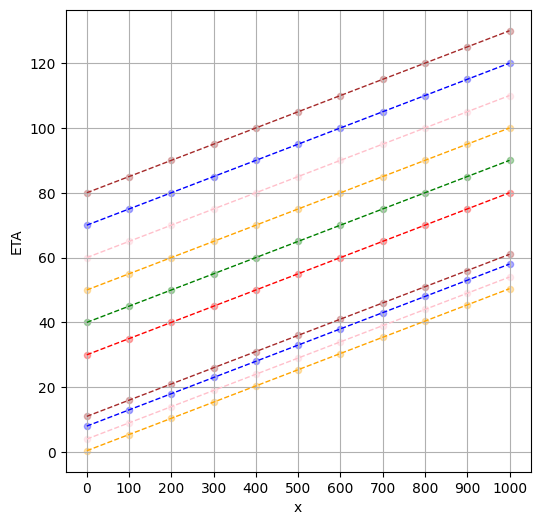

In [3]:
reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
# 各車がETAを決める部分
for idx, car in enumerate(CARS):
    desired_eta_list = car.create_desired_eta(WAYPOINTS)
    is_valid = reservation_table.validate(desired_eta_list)
    if is_valid:
        reservation_table.register(desired_eta_list)
    else:
        calibration_info = {"desired_list": desired_eta_list}
        calibrated_list, _ = reservation_table.calibrate_list(**calibration_info)
        # print(calibrated_list)
        # print()
        reservation_table.register(calibrated_list)
        car.my_list = calibrated_list

print(reservation_table.eta_table)
reservation_table.plot_with_noise([])

In [4]:
# cwp_table.waypoint_table
def create_noise(**kwargs):
    start_time = kwargs.get("start_time")
    TOTAL_LENGTH = kwargs.get("TOTAL_LENGTH")
    if start_time == None or TOTAL_LENGTH == None:
        raise ValueError("start_time, TOTAL_LENGTHが入力されていません")
    expected_noise_period = kwargs.get("expected_noise_period",10)
    return {"x":[610, 730], "t":[40,50]}
    
    

#### ここからノイズを入れたシミュレーションを開始

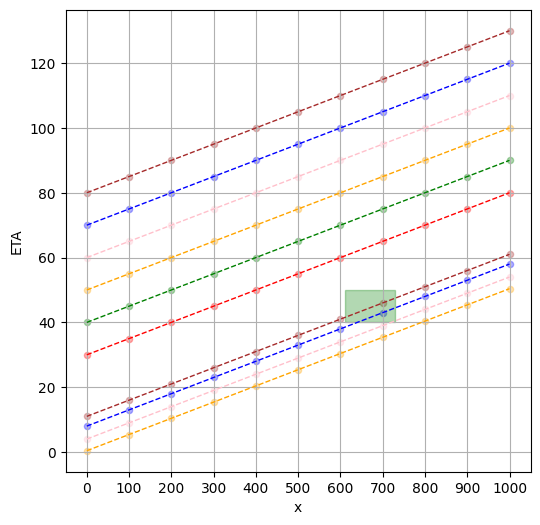

In [5]:
initial_cwp = copy.deepcopy(reservation_table)
noise = create_noise(start_time=5,TOTAL_LENGTH=1000)
reservation_table.plot_with_noise([noise])


### シミュレーションの流れ

各時刻において以下の計算を行う
1. ノイズ発生フェーズ: ある時刻にもしノイズがなければ一定確率で発生させる
2. 情報更新フェーズ

   ノイズ発生フェーズで生じたノイズと、直前の時刻での情報更新に基づいて影響を受ける車を列挙.
   
   `reactive_cars`に格納
4. `reactive_cars`の先頭車がノイズに反応(処理としては`cars.react_to_noise()`).

   `cwp_table`を書き換える
6. 今の状態で一歩前進

In [6]:
simulation = DFRSimulation(TOTAL_TIME = 8.5, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                          reservation_table = reservation_table)
simulation.conduct_simulation()


t=0.4, next_car=1, current_noise= [{'x': [610, 730], 't': [40, 50]}]
======update occured!=======
car_idx=0
直接ノイズの影響を受けるもの: []
他の車の影響: []
対象車: []

t=4.0, next_car=2, current_noise= [{'x': [610, 730], 't': [40, 50]}]
======update occured!=======
car_idx=0
======update occured!=======
car_idx=1
直接ノイズの影響を受けるもの: [1]
他の車の影響: []
対象車: [1]
avoidance by idx=1
[20.27777777777778] 30
36.0 3 30
delta_t=36.0, 
 到達可能距離:{'distance': 1063.3333333333333, 'v_end': 30}
reservation:     waypoint_idx       x   eta  car_idx      type
0             0.0     0.0   8.0        2  waypoint
1             1.0   100.0  13.0        2  waypoint
2             2.0   200.0  18.0        2  waypoint
3             3.0   300.0  23.0        2  waypoint
4             4.0   400.0  28.0        2  waypoint
..            ...     ...   ...      ...       ...
111           8.0   800.0  44.0        1  waypoint
112           9.0   900.0  49.0        1  waypoint
113          10.0  1000.0  54.0        1  waypoint
114           NaN   61

In [7]:
table = simulation.reservation_table
print(table.eta_table)

     waypoint_idx       x        eta  car_idx      type
0             0.0     0.0  11.000000        3  waypoint
1             1.0   100.0  16.000000        3  waypoint
2             2.0   200.0  21.000000        3  waypoint
3             3.0   300.0  26.000000        3  waypoint
4             4.0   400.0  31.000000        3  waypoint
..            ...     ...        ...      ...       ...
117           8.0   800.0  55.639877        2  waypoint
118           9.0   900.0  58.608233        2  waypoint
119          10.0  1000.0  61.576588        2  waypoint
120           NaN   610.0  50.000003        2     noise
121           NaN   730.0  53.562029        2     noise

[122 rows x 5 columns]


[0.4, 4.0, 8.0, 11.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0]


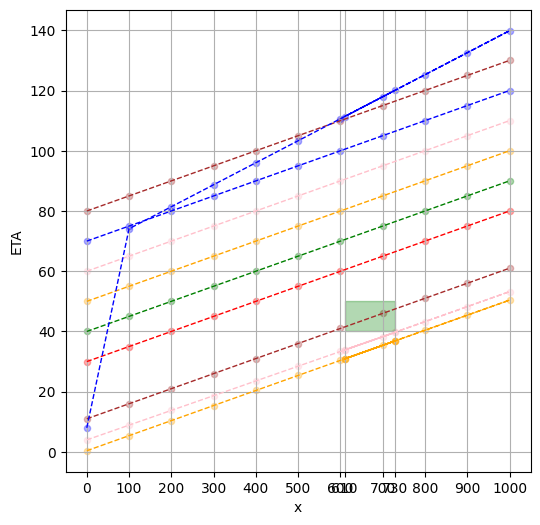

In [8]:
# print(simulation.reservation_table.eta_table[90:])
cars = simulation.CARS
print([car.itinerary[0]["eta"] for car in cars])# new_eta = [{'waypoint_idx': 0, 'x': 0.0, 'eta': 6.192323335817964, 'car_idx': 1}, {'waypoint_idx': 1, 'x': 100.0, 'eta': 6.773999748762652, 'car_idx': 1}, {'waypoint_idx': 2, 'x': 200.0, 'eta': 10.107333082095984, 'car_idx': 1}, {'waypoint_idx': 3, 'x': 300.0, 'eta': 13.440666415429318, 'car_idx': 1}, {'waypoint_idx': 4, 'x': 400.0, 'eta': 16.77399974876265, 'car_idx': 1}, {'waypoint_idx': 5, 'x': 500.0, 'eta': 20.107333082095984, 'car_idx': 1}, {'waypoint_idx': 6, 'x': 600.0, 'eta': 23.44066641542932, 'car_idx': 1}, {'waypoint_idx': 7, 'x': 700.0, 'eta': 26.773999748762648, 'car_idx': 1}, {'waypoint_idx': 8, 'x': 800.0, 'eta': 31.273999748762648, 'car_idx': 1}, {'waypoint_idx': 9, 'x': 900.0, 'eta': 36.27399974876265, 'car_idx': 1}, {'waypoint_idx': 10, 'x': 1000.0, 'eta': 41.27399974876265, 'car_idx': 1}]
simulation.reservation_table.plot_with_noise(noise_list=[noise])

In [19]:
a = [1,2,5]
a[-1] if len(a) > 0 else 0

5

In [20]:
def generate_random_number(center, size=1):
    std_dev = (center * 0.10) / 2 # 標準偏差を設定. 
    random_numbers = np.random.normal(center, std_dev, size)

    return random_numbers

In [11]:
df = cwp_table.waypoint_table
new_eta = [10] * 11
cwp_table.update_with_request(car_idx=0, new_eta=new_eta)
cwp_table.waypoint_table

11


,waypoint_idx,x,eta,car_idx
0,0,0.0,1.697172,1
1,1,100.0,8.569804,1
2,2,200.0,13.569804,1
3,3,300.0,18.569804,1
4,4,400.0,23.569804,1
...,...,...,...,...
105,6,600.0,10.000000,0
106,7,700.0,10.000000,0
107,8,800.0,10.000000,0
108,9,900.0,10.000000,0


In [12]:
"""
noiseの影響範囲にあたっている車はETAの変更を行う。
"""
for idx, car in enumerate(CARS):
    desired_eta_list = car.create_desired_eta(WAYPOINTS)
    is_valid = cwp_table.validate(desired_eta_list)
    if is_valid:
        cwp_table.register(desired_eta_list)
    else:
        calibration_info = {"desired_list": desired_eta_list}
        calibrated_list, _ = cwp_table.calibrate_list(**calibration_info)
        # print(calibrated_list)
        # print()
        df_to_add = pd.DataFrame(calibrated_list)
        cwp_table.register(calibrated_list)

In [12]:
car = CARS[1]
print(car.eta_table)

def check_noise_effect(noiseList, eta_table):
    return [check_single_noise_effect(noise, eta_table) for noise in noiseList]

def check_single_noise_effect(noise, eta_table):
    """
    returns if the ETAs will be blocked by the noise.
    waypoint間は等速で車が動くものと仮定している. 
    """
    print(noise)
    noise_x_range = noise["x"]
    noise_t_range = noise["t"]
    waypoint_x_list = [wp["x"] for wp in eta_table]
    waypoint_eta_list = [wp["eta"] for wp in eta_table]
    for i, x_coor in enumerate(waypoint_x_list):
        if i >= len(waypoint_x_list) -1: # 一番最後のwaypointに来た時
            return False
            
        x1, x2 = waypoint_x_list[i], waypoint_x_list[i+1]
        t1, t2 = waypoint_eta_list[i], waypoint_eta_list[i+1]
        # print(f"(x1,t1)=({x1}, {t1})")
        if (x1 < noise_x_range[0] and x2 < noise_x_range[0]) or (x1 > noise_x_range[1] and x2 > noise_x_range[1]):
            continue  # Both points are on the same side of the x range
        if (t1 < noise_t_range[0] and t2 < noise_t_range[0]) or (t1 > noise_t_range[1] and t2 > noise_t_range[1]):
            continue
        if x1 != x2:
            slope = (t2 - t1) / (x2 - x1)
            t_at_x_min = t1 + slope * (noise_x_range[0] - x1)
            t_at_x_max = t1 + slope * (noise_x_range[1] - x1)
            # print(f"{slope} = ({t2} - {t1}) / ({x2} - {x1})")
            # print(f"{t_at_x_min} = {t1} + {slope} * ({noise_x_range[0]} - {x1})")
            if (noise_t_range[0] <= t_at_x_min <= noise_t_range[1]) or (noise_t_range[0] <= t_at_x_max <= noise_t_range[1]):
                return True    

car_list = [idx for idx,car in enumerate(CARS) if check_single_noise_effect(noise, car.eta_table)]
print(car_list)

[{'waypoint_idx': 0, 'x': 0.0, 'eta': 6.401713970409634, 'car_idx': 1}, {'waypoint_idx': 1, 'x': 100.0, 'eta': 11.401713970409634, 'car_idx': 1}, {'waypoint_idx': 2, 'x': 200.0, 'eta': 16.401713970409634, 'car_idx': 1}, {'waypoint_idx': 3, 'x': 300.0, 'eta': 21.401713970409634, 'car_idx': 1}, {'waypoint_idx': 4, 'x': 400.0, 'eta': 26.401713970409634, 'car_idx': 1}, {'waypoint_idx': 5, 'x': 500.0, 'eta': 31.401713970409634, 'car_idx': 1}, {'waypoint_idx': 6, 'x': 600.0, 'eta': 36.40171397040963, 'car_idx': 1}, {'waypoint_idx': 7, 'x': 700.0, 'eta': 41.40171397040963, 'car_idx': 1}, {'waypoint_idx': 8, 'x': 800.0, 'eta': 46.40171397040963, 'car_idx': 1}, {'waypoint_idx': 9, 'x': 900.0, 'eta': 51.40171397040963, 'car_idx': 1}, {'waypoint_idx': 10, 'x': 1000.0, 'eta': 56.40171397040963, 'car_idx': 1}]
{'x': [610, 730], 't': [40, 50]}
{'x': [610, 730], 't': [40, 50]}
{'x': [610, 730], 't': [40, 50]}
{'x': [610, 730], 't': [40, 50]}
{'x': [610, 730], 't': [40, 50]}
{'x': [610, 730], 't': [40

### ここから下はDebug用のセル

In [6]:
# Initialize
car_0 = CARS[0]
print(arrival_times)
car_0.arrival_time

[1.1514412675820007, 20.670029824891007, 21.993481994314482, 30.18365737679346, 35.091883812613865, 45.16063044492818, 46.75884290964873, 52.515749460062686, 52.90767092789682, 58.33068176234094]


1.1514412675820007

In [4]:
a = [3,4,6,1,2]
print(a.index(max(a)))

2


In [14]:
a = [1]
not a

False